In [23]:
import torch
import matplotlib.pyplot as plt
import sys
sys.path.append('../../')
import copy
import numpy as np
from models.fno import FNO
from models.pfno import PNO_Wrapper, PFNO
from models.laplace import LA_Wrapper
from models.mcdropout import generate_mcd_samples
from data.datasets import ERA5Dataset
from matplotlib.colors import Normalize, CenteredNorm
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader
import cmcrameri
import cmcrameri.cm as cmc
import matplotlib as mpl
from matplotlib.colors import ListedColormap
from matplotlib import colormaps as cmp

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.empty_cache()

plt.rcParams['image.cmap'] = "cmc.vik"

# Load best predictions

In [2]:
batch_size = 16
n_samples = 100 # Samples to create from predictive distributions
alpha = 0.05 # Parameter for confidence interval

data_dir = "../../data/era5/"
checkpoint_path = "/home/groups/ai/scholl/pfno/weights/era5/fno/"

sr_dropout_path = checkpoint_path + "20240925_115247_era5_fno_sr_dropout/Datetime_20240925_115259_Loss_era5_FNO_scoring-rule-dropout_dropout_0.2.pt"
laplace_path = checkpoint_path + "20241008_125404_era5_fno_laplace/Datetime_20241008_125429_Loss_era5_FNO_laplace_dropout_0.01.pt"
dropout_path = checkpoint_path + "20240922_105401_era5_fno_dropout/Datetime_20240922_105416_Loss_era5_FNO_dropout_dropout_0.05.pt"
sr_reparam_path = checkpoint_path + "20240920_094424_era5_fno_sr_reparam/Datetime_20240920_094438_Loss_era5_FNO_scoring-rule-reparam_dropout_0.1.pt"

In [3]:
data_dir = "../../data/era5/"
test_data = ERA5Dataset(data_dir, var = "test")

lat,lon,t = test_data.get_coordinates(normalize = False)
L = test_data.get_domain_range()
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)

data_mean = test_data.mean
data_std = test_data.std
n_test = len(test_loader)

In [41]:
dropout_model = FNO(n_modes=(10,12, 12), hidden_channels=20, in_channels = 4, dropout=0.05, lifting_channels = 128, projection_channels=128).to(device)
dropout_cp = torch.load(dropout_path, map_location=torch.device(device))
dropout_model.load_state_dict(dropout_cp)

laplace_model = FNO(n_modes=(10,12, 12), hidden_channels=20, in_channels = 4, dropout=0.01, lifting_channels = 128, projection_channels=128).to(device)
la_model = LA_Wrapper(laplace_model)
la_model.load_state_dict(laplace_path)

pfno_reparam = PFNO(n_modes=(10,12, 12), hidden_channels=20, in_channels = 4, dropout=0.1, lifting_channels = 128, projection_channels=128, n_samples = n_samples).to(device)
pfno_cp = torch.load(sr_reparam_path, map_location=torch.device(device))
pfno_reparam.load_state_dict(pfno_cp)

sr_dropout_model = FNO(n_modes=(10,12, 12), hidden_channels=20, in_channels = 4, dropout=0.2, lifting_channels = 128, projection_channels=128).to(device)
sr_dropout_cp = torch.load(sr_dropout_path, map_location=torch.device(device))
pfno_dropout = PNO_Wrapper(sr_dropout_model, n_samples = n_samples)
pfno_dropout.load_state_dict(sr_dropout_cp)

<All keys matched successfully>

# Predictions

In [53]:
# Generate random samples for plotting
np.random.seed(42)
samples = np.random.randint(0,n_test,1)

In [54]:
pfno_dropout.train()
dropout_model.train()
pfno_reparam.eval()
""" Prediction """
pred_pfno_dropout = []
pred_pfno_reparam = []
pred_dropout = []
pred_la = []

with torch.no_grad():    
    index = 0
    for sample in samples:
        a,u = test_data.__getitem__(sample)
        a = a.to(device).unsqueeze(0)
        u = u.to(device).unsqueeze(0)
        dropout_pred = generate_mcd_samples(dropout_model, a, u.shape, n_samples=n_samples)
        pfno_dropout_pred = pfno_dropout(a, n_samples = n_samples)
        pfno_reparam_pred = pfno_reparam(a)
        la_pred = la_model.predictive_samples(a)

        pred_dropout.append( dropout_pred )
        pred_pfno_dropout.append( pfno_dropout_pred )
        pred_pfno_reparam.append( pfno_reparam_pred )
        pred_la.append( la_pred )


pred_pfno_dropout = torch.cat(pred_pfno_dropout, dim = 0).cpu().numpy()
pred_pfno_reparam = torch.cat(pred_pfno_reparam, dim = 0).cpu().numpy()
pred_dropout = torch.cat(pred_dropout, dim = 0).cpu().numpy()
pred_la = torch.cat(pred_la, dim = 0).cpu().numpy()

In [55]:
def plot_statistics(truth, preds, names, grid, t, save_path = None, alpha = 0.05):
    n_models = len(preds)
    lat, lon = grid
    truth = truth[:,:,t].squeeze()

    tick_size = 16
    title_size = 19
    mpl.rcParams['xtick.labelsize'] = tick_size
    mpl.rcParams['ytick.labelsize'] = tick_size

    # Discrete colorbar
    viridis = cmp.get_cmap('viridis')    
    col_dict = {0: viridis(0),
                1: viridis(0.999)}

    # We create a colormar from our list of colors
    cmap_coverage = ListedColormap([col_dict[x] for x in col_dict.keys()])

    # Get scalings
    pred_array = np.array(preds)
    mse_norm = Normalize(vmin = np.power((truth - pred_array.mean(axis = -1)),2).min(), vmax = np.power((truth - pred_array.mean(axis = -1)),2).max())
    std_norm = Normalize(vmin = 0, vmax = pred_array.std(axis = -1).max())
    

    fig, axs = plt.subplots(3,n_models, figsize = (20,10), sharex=True, sharey=True, subplot_kw={'projection': ccrs.PlateCarree()},
                            layout = "constrained")

    for ax in axs.ravel():
        ax.set_extent([lon[0], lon[-1], lat[0], lat[-1]], crs=ccrs.PlateCarree())
        ax.add_feature(cfeature.COASTLINE)
        
    for m, pred in enumerate(preds):        
        pred = pred[:,t].squeeze()
        # Calculate coverage
        q_lower = np.quantile(pred,alpha/2, axis = -1)
        q_upper = np.quantile(pred,1-alpha/2, axis = -1)
        coverage = (truth>q_lower) & (truth<q_upper)
        im1 = axs[0,m].pcolormesh(lon, lat, np.power((truth - pred.mean(axis = -1)),2), shading = "nearest", cmap = "cmc.vik", norm = mse_norm, rasterized = True)
        im2 = axs[1,m].pcolormesh(lon, lat,pred.std(axis = -1), shading = "nearest", cmap = "cmc.lipari", norm = std_norm, rasterized = True)
        im3 = axs[2,m].pcolormesh(lon, lat,coverage, shading = "nearest", cmap = cmap_coverage, rasterized = True)
        axs[0,m].set_title(names[m], fontsize = 24)

    cb1 = fig.colorbar(im1, ax = axs[0,m])
    cb1.ax.tick_params(labelsize=tick_size) 
    cb1.set_label('Squared error',size=title_size)
    cb2 = fig.colorbar(im2, ax = axs[1,m], label = "Standard deviation")
    cb2.ax.tick_params(labelsize=tick_size)
    cb2.set_label('Standard deviation',size=title_size)
    cb3 = fig.colorbar(im3, ax = axs[2,m], label = "", ticks = np.array([0,1]))
    cb3.ax.tick_params(labelsize=tick_size)
    cb3.set_label(r"Coverage ($\alpha = 0.05$)",size=title_size)

    for i in range(3):
        axs[i,0].set_xticks([])
        axs[i,0].set_yticks([])
   # fig.tight_layout()

    if save_path is not None:
        plt.savefig(save_path, dpi = 300, bbox_inches = "tight")
    
    plt.show()

In [56]:
def plot_predictions(truth, preds, names, grid, t, save_path = None, alpha = 0.05):
    n_models = len(preds)
    lat, lon = grid
    truth = truth[:,:,t].squeeze()

    tick_size = 16
    title_size = 19
    mpl.rcParams['xtick.labelsize'] = tick_size
    mpl.rcParams['ytick.labelsize'] = tick_size

    # Discrete colorbar
    viridis = cmp.get_cmap('viridis')    
    col_dict = {0: viridis(0),
                1: viridis(0.999)}

    # We create a colormar from our list of colors
    cmap_coverage = ListedColormap([col_dict[x] for x in col_dict.keys()])

    # Get scalings
    pred_array = np.array(preds)
    #pred_norm = Normalize(vmin = pred_array.mean(axis = -1).min(), vmax = pred_array.mean(axis = -1).max())
    pred_norm = CenteredNorm(vcenter = 0, halfrange = 25)
    std_norm = Normalize(vmin = 0, vmax = pred_array.std(axis = -1).max())
    

    fig, axs = plt.subplots(4, n_models, figsize = (20,14), sharex=True, sharey=True, subplot_kw={'projection': ccrs.PlateCarree()},
                            layout = "constrained")

    for ax in axs.ravel():
        ax.set_extent([lon[0], lon[-1], lat[0], lat[-1]], crs=ccrs.PlateCarree())
        ax.add_feature(cfeature.COASTLINE)
        
    for m, pred in enumerate(preds):        
        pred = pred[:,t].squeeze()
        # Calculate coverage
        q_lower = np.quantile(pred,alpha/2, axis = -1)
        q_upper = np.quantile(pred,1-alpha/2, axis = -1)
        coverage = (truth>q_lower) & (truth<q_upper)
        im1 = axs[0,m].pcolormesh(lon, lat ,truth, shading = "nearest", cmap = "cmc.vik", rasterized = True, norm = pred_norm)
        im1 = axs[1,m].pcolormesh(lon, lat ,pred.mean(axis = -1), shading = "nearest", cmap = "cmc.vik", norm = pred_norm, rasterized = True)
        im2 = axs[2,m].pcolormesh(lon, lat,pred.std(axis = -1), shading = "nearest", cmap = "cmc.lipari", norm = std_norm, rasterized = True)
        im3 = axs[3,m].pcolormesh(lon, lat,coverage, shading = "nearest", cmap = cmap_coverage, rasterized = True)
        axs[0,m].set_title(names[m], fontsize = 24)

    cb1 = fig.colorbar(im1, ax = axs[0,m])
    cb1.ax.tick_params(labelsize=tick_size) 
    cb1.set_label('Ground truth [C°]',size=title_size)
    cb1 = fig.colorbar(im1, ax = axs[1,m])
    cb1.ax.tick_params(labelsize=tick_size) 
    cb1.set_label('Prediction [C°]',size=title_size)
    cb3 = fig.colorbar(im2, ax = axs[2,m], label = "Standard deviation")
    cb3.ax.tick_params(labelsize=tick_size)
    cb3.set_label('Standard deviation',size=title_size)
    cb4 = fig.colorbar(im3, ax = axs[3,m], label = "", ticks = np.array([0,1]))
    cb4.ax.tick_params(labelsize=tick_size)
    cb4.set_label(r"Coverage ($\alpha = 0.05$)",size=title_size)

    for i in range(4):
        axs[i,0].set_xticks([])
        axs[i,0].set_yticks([])
   # fig.tight_layout()

    if save_path is not None:
        plt.savefig(save_path, dpi = 300, bbox_inches = "tight")
    
    plt.show()

# Plots

In [57]:
idx = 0

a,u = test_data.__getitem__(samples[idx])
a = a.unsqueeze(0).numpy()
u = u.unsqueeze(0).numpy()

preds = [pred_dropout[idx], pred_la[idx], pred_pfno_dropout[idx], pred_pfno_reparam[idx]]
names = ['Dropout', 'Laplace', 'PNO Dropout', 'PNO Reparam']

# Renormalize
preds = [pred*data_std + data_mean - 273.15 for pred in preds]
u = u*data_std + data_mean -273.15 # Transform to Celsius

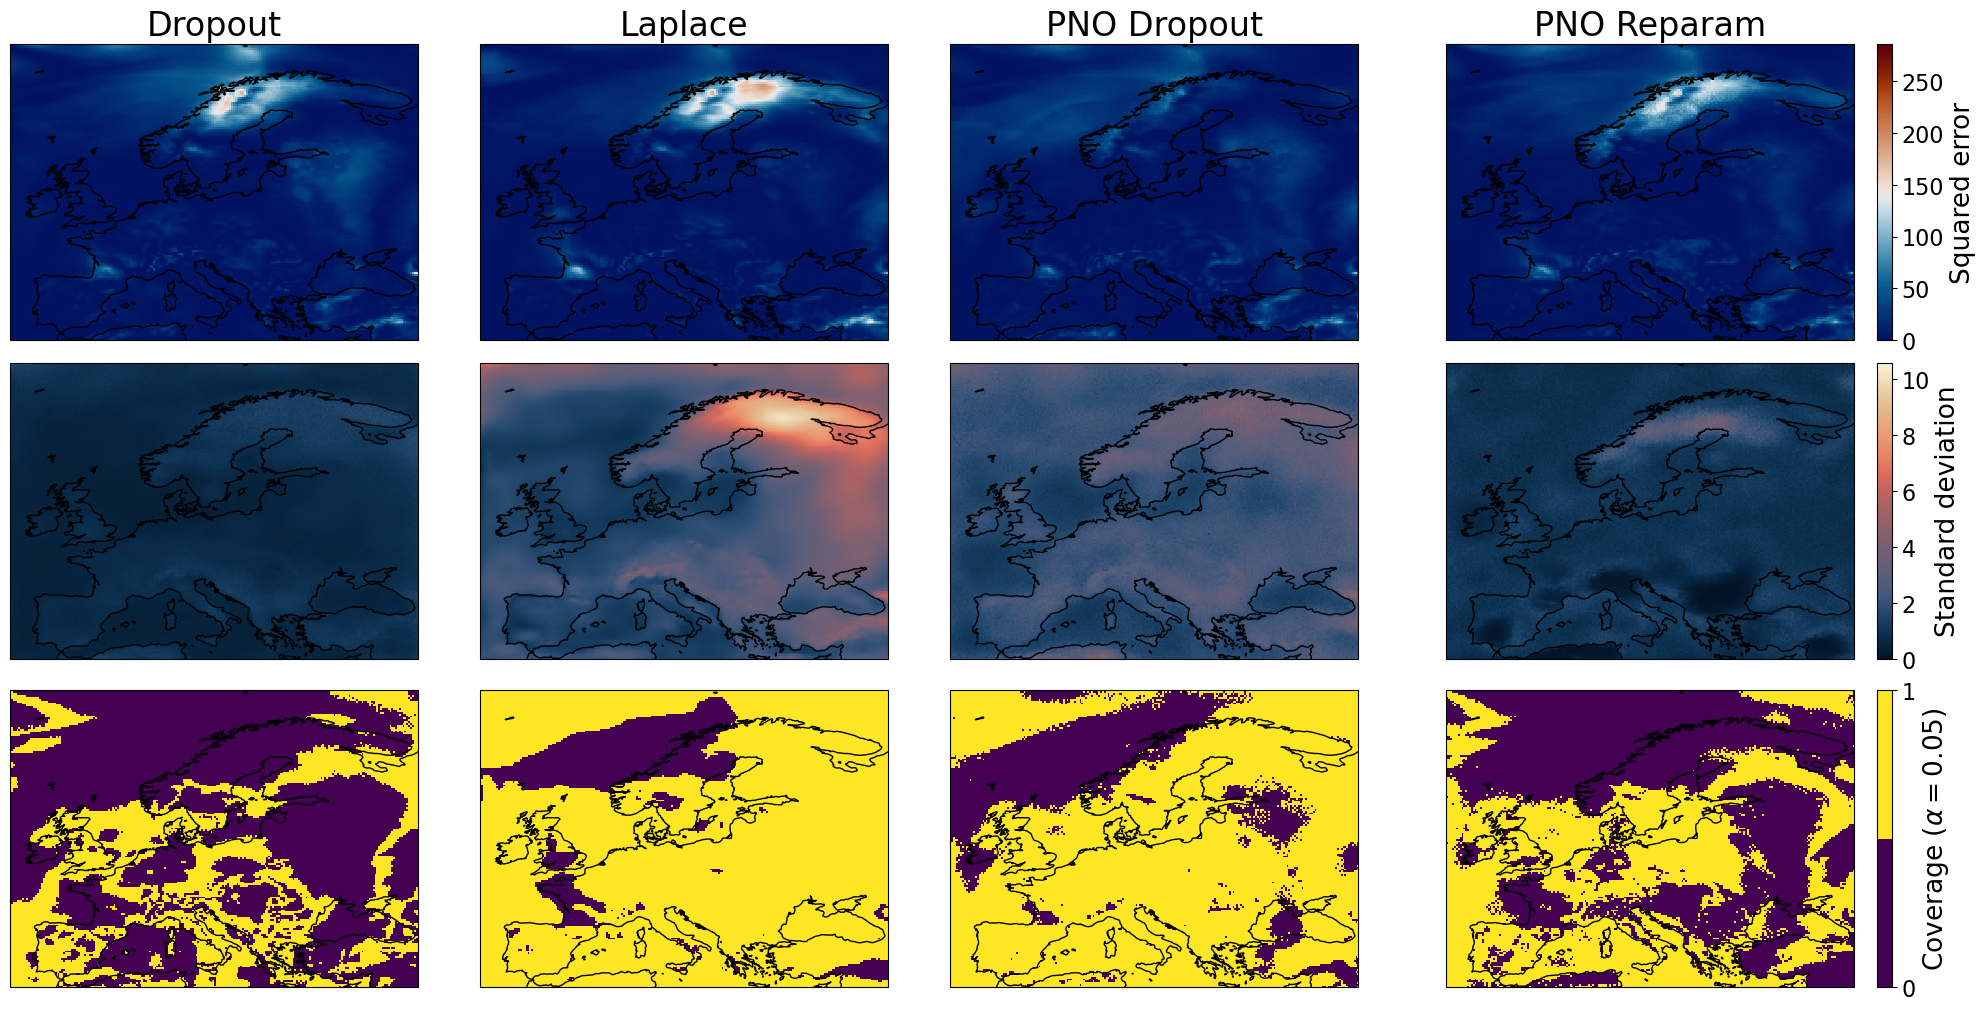

In [58]:
plot_statistics(u, preds, names, (lat,lon), t = 9, save_path = "plots/era5_statistics_10h.pdf", alpha = 0.05)

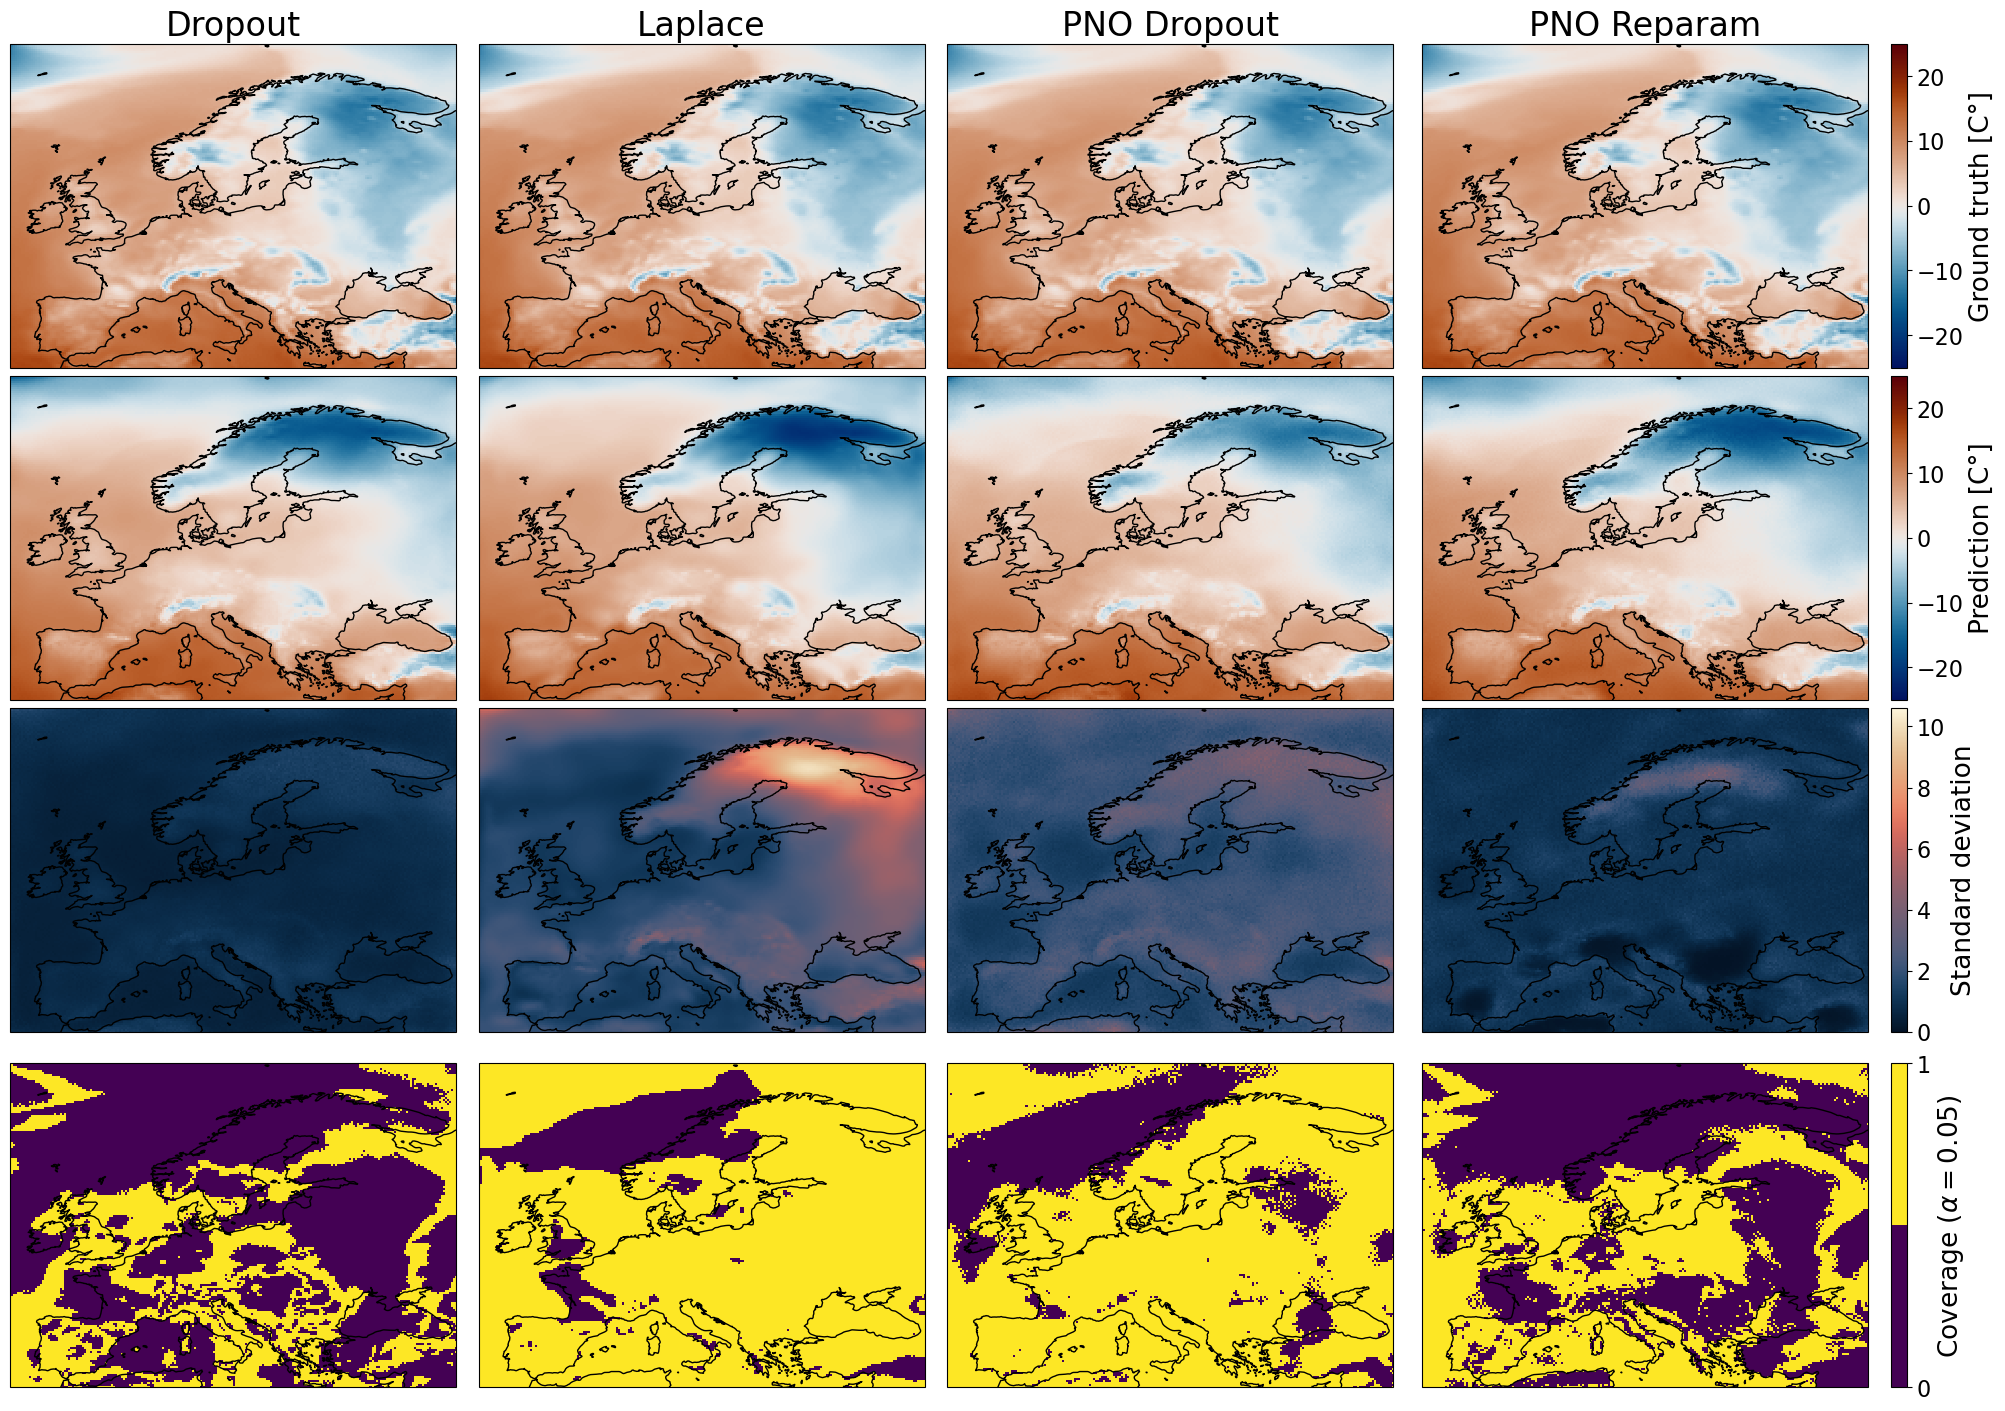

In [59]:
plot_predictions(u, preds, names, (lat,lon), t = 9, save_path = "plots/era5_predictions_10h.pdf", alpha = 0.05)

# Plot spatial metrics

In [60]:
def plot_spatial_metrics(names, path, grid, t=3, save_path = None, alpha = 0.05):
    n_models = len(names)
    fig_names = ["Dropout", "PNO Dropout", "PNO Reparam"]
    lat, lon = grid

    tick_size = 16
    title_size = 19
    mpl.rcParams['xtick.labelsize'] = tick_size
    mpl.rcParams['ytick.labelsize'] = tick_size

    # Get scalings
    crps_norm = Normalize(vmin = 0, vmax = 2.5)
    coverage_norm = Normalize(vmin = 0, vmax = 100)
    

    fig, axs = plt.subplots(2,n_models, figsize = (20,10), sharex=True, sharey=True, subplot_kw={'projection': ccrs.PlateCarree()},
                            layout = "constrained")

    for ax in axs.ravel():
        ax.set_extent([lon[0], lon[-1], lat[0], lat[-1]], crs=ccrs.PlateCarree())
        ax.add_feature(cfeature.COASTLINE)
        
    for m in range(n_models):        
        coverage = np.load(path + f"era5_{names[m]}_{(t+1)*6}h_coverage.npy")
        crps = np.load(path + f"era5_{names[m]}_{(t+1)*6}h_crps.npy")
        im1 = axs[0,m].pcolormesh(lon, lat, crps, shading = "nearest", cmap = "cmc.vik", norm = crps_norm, rasterized = True)
        im2 = axs[1,m].pcolormesh(lon,lat, coverage*100, shading = "nearest", cmap = "cmc.lipari", norm = coverage_norm, rasterized = True)
        axs[0,m].set_title(fig_names[m], fontsize = 24)

    cb1 = fig.colorbar(im1, ax = axs[0,m])
    cb1.ax.tick_params(labelsize=tick_size) 
    cb1.set_label('CRPS',size=title_size)
    cb2 = fig.colorbar(im2, ax = axs[1,m])
    cb2.ax.tick_params(labelsize=tick_size)
    cb2.set_label('Coverage [%]',size=title_size)


    for i in range(2):
        axs[i,0].set_xticks([])
        axs[i,0].set_yticks([])
   # fig.tight_layout()

    if save_path is not None:
        plt.savefig(save_path, dpi = 300, bbox_inches = "tight")
    
    plt.show()

In [61]:
path = "../../evaluation/spatial_metrics/"
names = ["dropout", "scoring-rule-dropout", "scoring-rule-reparam"]

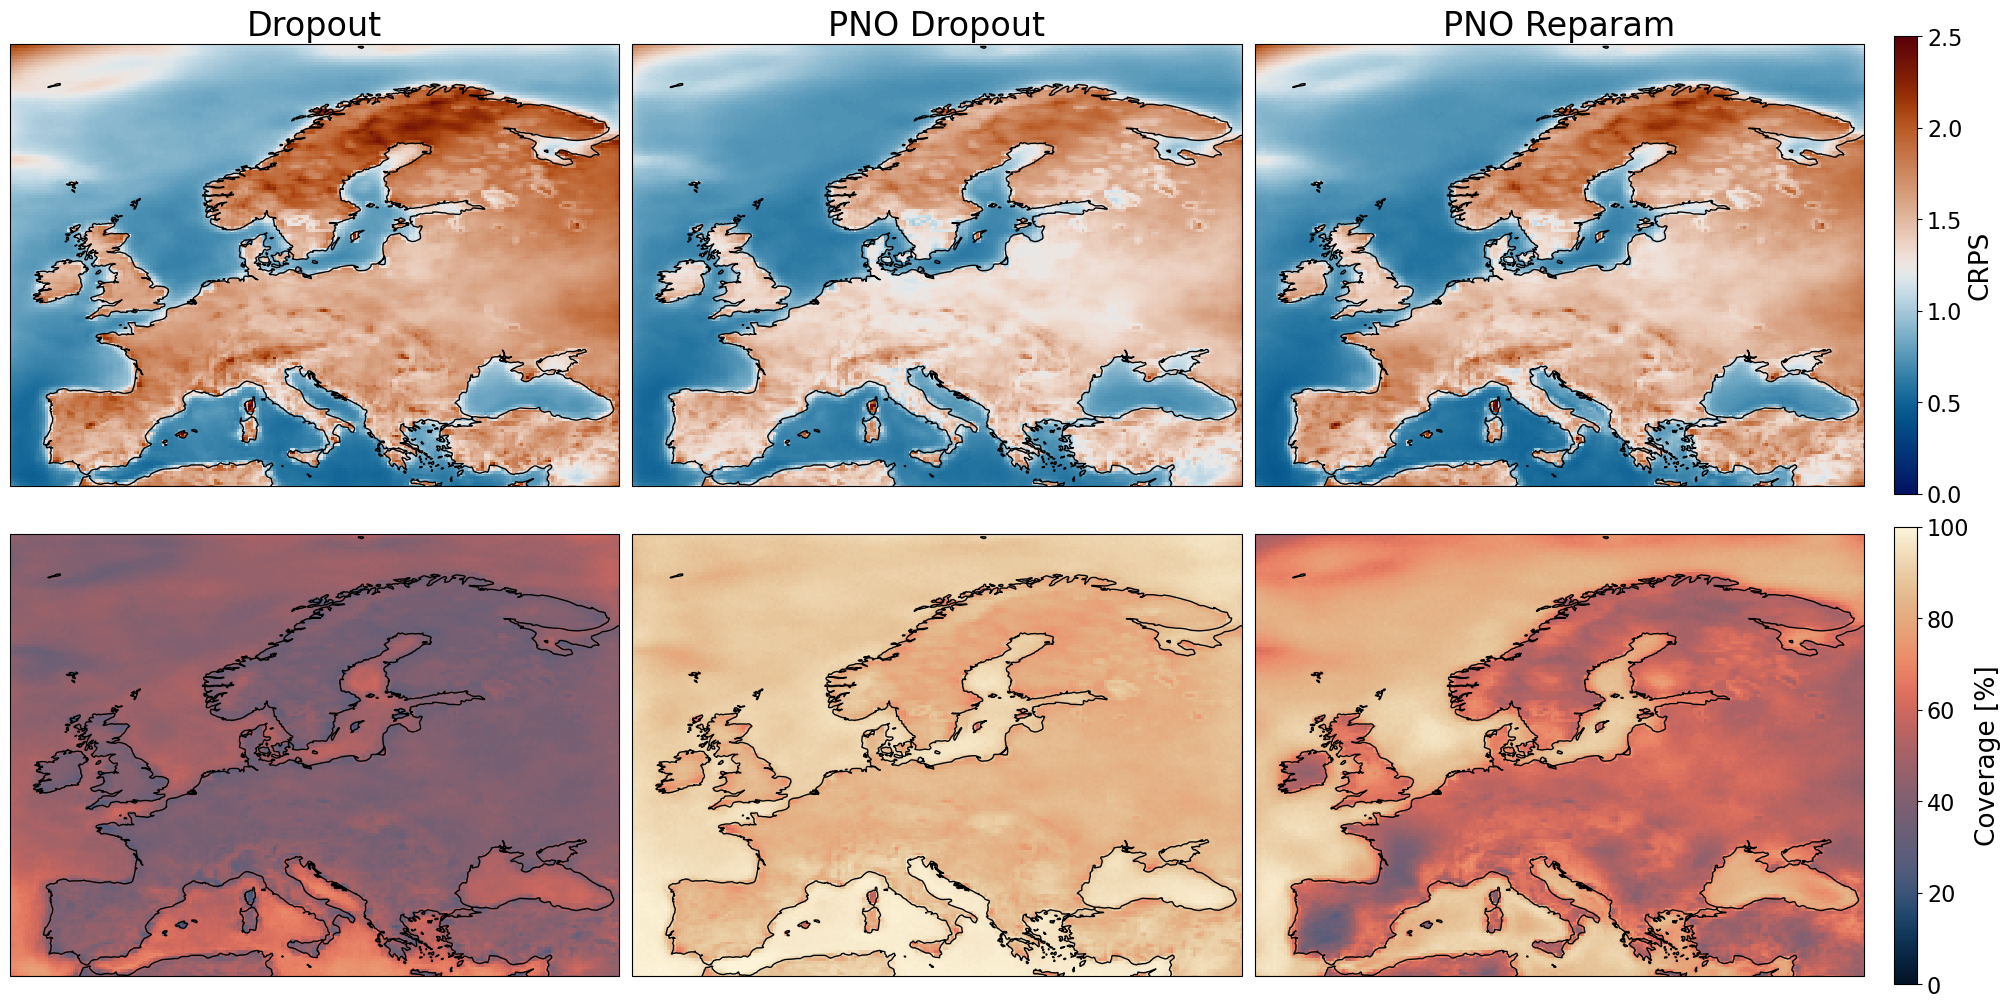

In [62]:
plot_spatial_metrics(names, path, (lat,lon))